### Compute F-test, permutations temporal clusters
fonction mne.stats.permutation_cluster_test

In [1]:
from brainpipe.system import study
from brainpipe.visual import tilerplot
import numpy as np
from mne.stats import permutation_cluster_test
from os import listdir
from os.path import exists, join
from itertools import product
import glob
from scipy.sparse import eye
import matplotlib.pyplot as plt

-> Olfacto loaded
stat rsa for  LEFC HC low False
stat rsa for  <class 'str'> <class 'str'> <class 'str'> <class 'str'>
LEFC HC 0 / 8
Using a threshold of 3.977779
stat_fun(H1): min=nan max=nan
Running initial clustering
Found 0 clusters
LEFC HC 1 / 8
Using a threshold of 3.977779
stat_fun(H1): min=nan max=nan
Running initial clustering
Found 2 clusters
Permuting 1023 times...
[                                                        ]   0.20%  |   

/home/karim/anaconda3/envs/mne_coreg/lib/python3.6/site-packages/mne/stats/parametric.py:119: RuntimeWarning: invalid value encountered in subtract
  sstot = ss_alldata - square_of_sums_alldata / float(n_samples)
/home/karim/anaconda3/envs/mne_coreg/lib/python3.6/site-packages/mne/stats/parametric.py:123: RuntimeWarning: invalid value encountered in subtract
  ssbn -= square_of_sums_alldata / float(n_samples)
<ipython-input-4-2a2b79490825>:31: RuntimeWarning: Provided stat_fun does not treat variables independently. Setting buffer_size to None.
  tail=1,threshold=None,check_disjoint=True,step_down_p=0.05)
/home/karim/anaconda3/envs/mne_coreg/lib/python3.6/site-packages/mne/stats/cluster_level.py:355: RuntimeWarning: invalid value encountered in greater
  x_ins = [np.logical_and(x > thresh, include)]
<ipython-input-4-2a2b79490825>:31: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  tail=1,threshold=None,check_disjoint=True,step_down_p=0.05)
<ipython-inp

[........................................................] 100.00%  |   
Computing cluster p-values
Step-down-in-jumps iteration #1 found 0 clusters to exclude from subsequent iterations
Done.
LEFC HC 2 / 8
Using a threshold of 3.977779
stat_fun(H1): min=nan max=nan
Running initial clustering
Found 12 clusters
Permuting 1023 times...
[...                                                     ]   6.06%  |   

<ipython-input-4-2a2b79490825>:31: RuntimeWarning: Provided stat_fun does not treat variables independently. Setting buffer_size to None.
  tail=1,threshold=None,check_disjoint=True,step_down_p=0.05)


[........................................................] 100.00%  |   
Computing cluster p-values
Step-down-in-jumps iteration #1 found 0 clusters to exclude from subsequent iterations
Done.
LEFC HC 3 / 8
Using a threshold of 3.977779
stat_fun(H1): min=nan max=nan
Running initial clustering
Found 30 clusters
Permuting 1023 times...
[...                                                     ]   6.45%  |   

<ipython-input-4-2a2b79490825>:31: RuntimeWarning: Provided stat_fun does not treat variables independently. Setting buffer_size to None.
  tail=1,threshold=None,check_disjoint=True,step_down_p=0.05)


[........................................................] 100.00%  |   
Computing cluster p-values
Step-down-in-jumps iteration #1 found 2 clusters to exclude from subsequent iterations
Permuting 1023 times...
[........................................................] 100.00%  |   
Computing cluster p-values
Step-down-in-jumps iteration #2 found 0 additional clusters to exclude from subsequent iterations
Done.


/home/karim/anaconda3/envs/mne_coreg/lib/python3.6/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in subtract


FileNotFoundError: [Errno 2] No such file or directory: '/media/karim/Datas4To/1_Analyses_Intra_EM_Odor/Olfacto/feature/1_RSA_E_R_by_odor/figures_high_low_stat/RSA_LEFC_High_Low_HC_elec3.png'

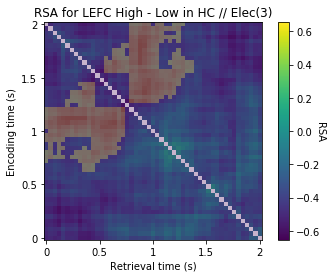

In [4]:
st = study('Olfacto')
path_rsa = join(st.path,'feature/1_RSA_E_R_by_odor/')
path_save = join(path_rsa,'figures_high_low_stat/')
subjects = ['LEFC','SEMC','PIRJ','FERJ','VACJ'] #CHAF not included no elec in ROIs
conds = ['low','high']
rois = ['HC','IFG','OFC']
average = 'False'
thresh = 0.05

for su, roi in product(subjects,rois):
    print('stat rsa for ',su,roi,conds[0],average)
    print('stat rsa for ',type(su),type(roi),type(conds[0]),type(average))
    filename_l = su+'_'+conds[0]+'_odor_*_'+roi+'_E_R_rsa_theta_avg='+average+'.npz'
    filename_h = su+'_'+conds[1]+'_odor_*_'+roi+'_E_R_rsa_theta_avg='+average+'.npz'
    files_low = [file for file in glob.glob(path_rsa+filename_l)]
    files_high = [file for file in glob.glob(path_rsa+filename_h)]
    #concatenate odors in the trials dimensions
    #nelecs,ncomb,nsamples,nsamples
    all_data_l = np.concatenate(([np.load(file)['rsa'] for file in files_low]),
                              axis=1)
    all_data_h = np.concatenate(([np.load(file)['rsa'] for file in files_high]),
                              axis=1)
    nelecs, nsamples = all_data_l.shape[0], all_data_l.shape[-1]
    
    for elec in range(nelecs):
        print(su,roi,elec,'/',nelecs)
        #compute statistics by electrode
        all_conds = [all_data_h[elec],all_data_l[elec]]
        connectivity = sum([eye(nsamples, nsamples, i) for i in range(-1, 2)])
        _, clu0, p0, _ = permutation_cluster_test(all_conds, connectivity=None,
                            tail=1,threshold=None,check_disjoint=True,step_down_p=0.05)
        idx = [i for i, p in enumerate(p0) if p < thresh]
        clu0 = np.array(clu0)
        
        if len(idx):
            clu0, p0 = clu0[idx,:,:], p0[idx]
            rsa_plot = np.mean(all_data_h[elec],axis=0)-np.mean(all_data_l[elec],axis=0)
            merge = np.zeros((nsamples,nsamples))
            for c in range(len(idx)):
                merge += clu0[c]

            #plot RSA difference map with statistics
            plotname = 'RSA_'+su+'_High_Low_'+roi+'_elec'+str(elec)+'.png'
            title = 'RSA for '+su+' High - Low in '+roi+' // Elec('+str(elec)+')'
            fig, ax = plt.subplots()
            plt.title(title)
            vmin, vmax = np.nanmin(rsa_plot), np.nanmax(rsa_plot)
            extr = abs(vmin) if abs(vmin)> vmax else vmax
            img1 = plt.imshow(rsa_plot,vmin=-extr,vmax=extr,origin='lower')
            size = rsa_plot.shape[0]-1
            ticks = [0,size/4,size/2,(size)*3/4,size]
            ticks_labels = [0,0.5,1,1.5,2]
            ax.set_xticks(ticks, minor=False)
            ax.set_yticks(ticks, minor=False)
            ax.set_xticklabels(ticks_labels)
            ax.set_yticklabels(ticks_labels)
            plt.xlabel('Retrieval time (s)')
            plt.ylabel('Encoding time (s)')
            cbar = plt.colorbar()
            cbar.set_label('RSA',rotation=270)
            
            #concat all masks for all clusters
            img2 = plt.imshow(merge,alpha=0.3,origin='lower')
            plt.savefig(path_save+plotname)
            plt.clf()
            plt.close()
